# Actor-Critic (AC) 
Below we will implement the actor-critic method with eligibility traces for the second agent. The implementation has $3$ main parts as follows:


*   **Helper Function:** Here we will import the libraries we need and implement our helper functions
*   **Implementation of (AC):** In this part we will implement the (AC) method used for the learning of the second agent
*   **Results**: Using the (AC) method, we will train the agent and produce our plots here



## Helper Function

### Uploading The Environment
Below we will upload the environment from our repository and import the libraries we need as well.

In [1]:
!rm -rf comp-767-Final-Project/; git clone https://github.com/navin-mordani/comp-767-Final-Project.git; cp comp-767-Final-Project/environments.py .

Cloning into 'comp-767-Final-Project'...
remote: Counting objects: 59, done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 59 (delta 12), reused 39 (delta 10), pack-reused 17
Unpacking objects: 100% (59/59), done.


In [0]:
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt
from environments import EnvSetTarget
from environments import EnvChaseTarget
import random
import sys
import os
from scipy.stats import bernoulli

### Random Step Taker
Below is a simple function that allows us to take a random action in the environment.

In [0]:
def random_step(max_step):
  return random.randint(0,max_step)


### Random Target Producer
Below is a simple function that generates a random target for the agent to chase.

In [0]:
def random_target(max_target):
  return random.randint(0,max_target)

### Softmax Function:
Below is a Softmax function, specifically designed for our purposes in the learning of the second agent. It takes in a feature vector $x$ and paramter vector $\theta$ then it returns the softmax of actions 0, 1, 2, 3 in an array.

In [0]:
def action4_softmax(x,theta):
  act0=np.exp(np.dot(np.append(x,np.array([1,0,0,0])),theta))
  act1=np.exp(np.dot(np.append(x,np.array([0,1,0,0])),theta))
  act2=np.exp(np.dot(np.append(x,np.array([0,0,1,0])),theta))
  act3=np.exp(np.dot(np.append(x,np.array([0,0,0,1])),theta))
  act_sum=act0+act1+act2+act3
  softmax_return=np.array([act0/act_sum,act1/act_sum,act2/act_sum,act3/act_sum,])
  return softmax_return

### Picking an Action
The function below takes as input a vector of probabilities of actions, then based on those probabilities it picks an action and returns it.

In [0]:
def choos_action(x):
  y=np.zeros(x.size)
  a=random.random()
  for i in range(x.size):
    y[i]=np.sum(x[:i+1])
    if a<=y[i]:
      return i

## Actor-Critic with Eligibility Traces (episodic)
Below function is based on the algorithm in Sattun and Barto page $274$. It runs the algorithm for one episode of the problem and then returns the parameters $\theta$ and $w$ at the end of that episod along with whether the episod was a success or failur (i.e. the reward of $+1$ or $-1$)

The actor is defined as:$$\pi(a|s,\theta)=softmax(h(s,a,\theta))$$
Where $h$ is the parameterized numerical preferences for each state-action pair. We define $h$ to be:
$$\theta^Tx(s,a)$$
This means that we define our preferences to be linear in features. Where the feature vector $x$ is simply given by:
$$[1,s,1,0,0,0]$$ $$[1,s,0,1,0,0]$$ $$[1,s,0,0,1,0]$$ $$[1,s,0,0,0,1]$$
For action 1, 2, 3, 4 respectively. The vetor $s$ here indicates the state of the agent. Note that under this definition we have:
$$\nabla_\theta\mathrm{ln}\pi(a|s,\theta)=x(s,a)-\sum_b\pi(b|s,\theta)x(s,b)$$
The critic function $\hat{v}(s,w)$ is given by $w^Tx(s)$ where $x(s)$ is the degree 1 polynomial feature of state $s$, therfore we have: $$x(s)=[1,s]$$. Note that in this definition we have: $$\nabla_w\hat{v}(s,a)=x(s)$$

In [0]:
def actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w,max_target=36):
  target=random_target(max_target)
  env = EnvChaseTarget(6,2,target)
  observation_old = env.reset(target)
  z_theta=np.zeros(theta.size)
  z_w=np.zeros(w.size)
  I=1
  done=False
  while not done:
    x_old=np.append(1,observation_old)    
    action=choos_action(action4_softmax(x_old,theta))
    if action==0:
      action_f=np.array([1,0,0,0])
    if action==1:
      action_f=np.array([0,1,0,0])
    if action==2:
      action_f=np.array([0,0,1,0])
    if action==3:
      action_f=np.array([0,0,0,1])      
    observation_new, reward, done, info = env.step(action)
    if observation_new[2]<0:
      observation_new[2]=0
    x_new=np.append(1,observation_new)
    if done:
      delta=reward-np.dot(x_old,w)
    else:
      delta=reward+gamma*(np.dot(x_new,w))-np.dot(x_old,w)
    z_w=gamma*lambda_w*z_w+I*x_old
    z_theta=gamma*lambda_theta*z_theta+I*(np.append(x_old,action_f)-action4_softmax(x_old,theta)[0]*np.append(x_old,np.array([1,0,0,0]))
                                          -action4_softmax(x_old,theta)[1]*np.append(x_old,np.array([0,1,0,0]))
                                         -action4_softmax(x_old,theta)[2]*np.append(x_old,np.array([0,0,1,0]))
                                         -action4_softmax(x_old,theta)[3]*np.append(x_old,np.array([0,0,0,1])))
    w=w+alpha_w*delta*z_w
    theta=theta+alpha_theta*delta*z_theta
    I=gamma*I
    observation_old=observation_new
    if done:
      break
  return theta, w, reward

## Results
In this section we will simulate the environment for our (AC) method to investiage the quality of its learning. This section has 3 parts as follows:


1.   **Test on Random Policy**: In this section we investigate the return of the environment of ranodm policy
2.   **AC Performance:** Here we will investigate the performance of the (AC) on the environment
3.   **Plots**: Produce a few plots here



### Test On Random Policy
Note that in this environment the maximum score any agent can achieve is $6\times 6=36$ with the probability of $(0.6)^6=0.046656$ or $4.6656\%$. Below we will compute the average return of the second player over $1,000,000$ episodes given that he plays randomly and the target he needs to achieve is randomly chosen.

In [5]:
epochs=1000000
max_target=36
avg_reward=0
for i in range(epochs):
  done=False
  target=random_target(max_target)
#  target=25
  env=EnvChaseTarget(6,2,target)
  initial_state=np.array([0,0,target])
  while not done:  
    action = random_step(3)
    observation, reward, done, info = env.step(action)
  avg_reward=avg_reward+reward
avg_reward=avg_reward/epochs
print(avg_reward)

-0.244094


### Actor-Critic Performance
Below we will investigate the perfomance of the (AC) method over a total of a little less than $5\mathrm{M}$ episodes averaged 10 times. Note that since this code was ran in google colab, we had to break the loops into smaller pieaces so that the server does not disconnect us. 

In [9]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=10000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=np.zeros(8)
  w=np.zeros(4)
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [10]:
avg_method=np.array([avg_reward])
improvement_method=np.array([0])

avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424  ]
[0.         0.69399494]


In [11]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [12]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904 ]
[0.         0.69399494 2.07051382]


In [13]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [14]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024 ]
[0.         0.69399494 2.07051382 9.77246471]


In [15]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [16]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778]


In [17]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [18]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896 ]


In [19]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [20]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287]


In [21]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [22]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169   ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766]


In [23]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [24]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856]


In [25]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [26]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132]


In [27]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [28]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904]


In [29]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [30]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143]


In [31]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [32]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511]


In [33]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [34]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517]


In [35]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [36]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367]


In [37]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [38]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306]


In [39]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [40]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397]


In [41]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [42]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347]


In [43]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [44]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465]


In [45]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [46]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439]


In [47]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [48]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914]


In [49]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [50]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931]


In [51]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [52]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519]


In [53]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [54]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361]


In [55]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [56]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909]


In [57]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [58]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657]


In [59]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [60]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921]


In [61]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [62]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172]


In [63]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [64]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949]


In [65]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [66]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527]


In [67]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [68]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073]


In [69]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [70]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845  ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883]


In [71]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [72]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833  ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272]


In [73]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [74]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833   -0.085   ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272 65.17734971]


In [75]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [76]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833   -0.085    -0.08166 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272 65.17734971 66.54567503]


In [77]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [78]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833   -0.085    -0.08166
 -0.08284 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272 65.17734971 66.54567503 66.06225471]


In [79]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [80]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833   -0.085    -0.08166
 -0.08284  -0.0849  ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272 65.17734971 66.54567503 66.06225471
 65.21831753]


In [81]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [82]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833   -0.085    -0.08166
 -0.08284  -0.0849   -0.08636 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272 65.17734971 66.54567503 66.06225471
 65.21831753 64.6201873 ]


In [83]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [84]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833   -0.085    -0.08166
 -0.08284  -0.0849   -0.08636  -0.07952 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272 65.17734971 66.54567503 66.06225471
 65.21831753 64.6201873  67.42238646]


In [85]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [86]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833   -0.085    -0.08166
 -0.08284  -0.0849   -0.08636  -0.07952  -0.07866 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272 65.17734971 66.54567503 66.06225471
 65.21831753 64.6201873  67.42238646 67.77470974]


In [87]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [88]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833   -0.085    -0.08166
 -0.08284  -0.0849   -0.08636  -0.07952  -0.07866  -0.0798  ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272 65.17734971 66.54567503 66.06225471
 65.21831753 64.6201873  67.42238646 67.77470974 67.30767655]


In [89]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [90]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833   -0.085    -0.08166
 -0.08284  -0.0849   -0.08636  -0.07952  -0.07866  -0.0798   -0.07478 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272 65.17734971 66.54567503 66.06225471
 65.21831753 64.6201873  67.42238646 67.77470974 67.30767655 69.36426131]


In [91]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [92]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833   -0.085    -0.08166
 -0.08284  -0.0849   -0.08636  -0.07952  -0.07866  -0.0798   -0.07478
 -0.08168 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272 65.17734971 66.54567503 66.06225471
 65.21831753 64.6201873  67.42238646 67.77470974 67.30767655 69.36426131
 66.53748146]


In [93]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [94]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833   -0.085    -0.08166
 -0.08284  -0.0849   -0.08636  -0.07952  -0.07866  -0.0798   -0.07478
 -0.08168  -0.07942 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272 65.17734971 66.54567503 66.06225471
 65.21831753 64.6201873  67.42238646 67.77470974 67.30767655 69.36426131
 66.53748146 67.46335428]


In [95]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [96]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833   -0.085    -0.08166
 -0.08284  -0.0849   -0.08636  -0.07952  -0.07866  -0.0798   -0.07478
 -0.08168  -0.07942  -0.08554 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272 65.17734971 66.54567503 66.06225471
 65.21831753 64.6201873  67.42238646 67.77470974 67.30767655 69.36426131
 66.53748146 67.46335428 64.95612346]


In [97]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [98]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833   -0.085    -0.08166
 -0.08284  -0.0849   -0.08636  -0.07952  -0.07866  -0.0798   -0.07478
 -0.08168  -0.07942  -0.08554  -0.07876 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272 65.17734971 66.54567503 66.06225471
 65.21831753 64.6201873  67.42238646 67.77470974 67.30767655 69.36426131
 66.53748146 67.46335428 64.

In [99]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [100]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833   -0.085    -0.08166
 -0.08284  -0.0849   -0.08636  -0.07952  -0.07866  -0.0798   -0.07478
 -0.08168  -0.07942  -0.08554  -0.07876  -0.07716 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272 65.17734971 66.54567503 66.06225471
 65.21831753 64.6201873  67.42238646 67.77470974 67.30767655 69.36426131
 66.53748146 67.46

In [101]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [102]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833   -0.085    -0.08166
 -0.08284  -0.0849   -0.08636  -0.07952  -0.07866  -0.0798   -0.07478
 -0.08168  -0.07942  -0.08554  -0.07876  -0.07716  -0.08078 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272 65.17734971 66.54567503 66.06225471
 65.21831753 64.6201873  67.42238646 67.77470974 67.30767655 69.36426131
 66.5374

In [103]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [104]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833   -0.085    -0.08166
 -0.08284  -0.0849   -0.08636  -0.07952  -0.07866  -0.0798   -0.07478
 -0.08168  -0.07942  -0.08554  -0.07876  -0.07716  -0.08078  -0.0763  ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272 65.17734971 66.54567503 66.06225471
 65.21831753 64.6201873  67.42238646 67.77470974 67.30767655 69.3642613

In [105]:
gamma=0.1
lambda_theta=0.5
lambda_w=lambda_theta
alpha_theta=0.0001
alpha_w=0.001
number_of_episods=100000
number_of_runs_for_average=10
average_success_v0=np.zeros(number_of_runs_for_average)
theta_saved=theta
w_saved=w

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  theta=theta_saved
  w=w_saved
  r_t=0
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)
    r_t+=temp
  r_t=r_t/number_of_episods
  average_success_v0[n]=r_t

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


In [106]:
avg_method=np.append(avg_method,np.average(average_success_v0))
temp=((np.average(average_success_v0)-avg_reward)/(-avg_reward))*100
improvement_method=np.append(improvement_method,temp)

print(avg_method)
print(improvement_method)

[-0.244094 -0.2424   -0.23904  -0.22024  -0.20586  -0.18986  -0.18036
 -0.169    -0.15884  -0.14996  -0.14094  -0.13526  -0.12486  -0.12716
 -0.11836  -0.11438  -0.10854  -0.11348  -0.09984  -0.10764  -0.10262
 -0.09454  -0.09288  -0.09244  -0.10032  -0.08844  -0.08994  -0.09318
 -0.09078  -0.08884  -0.08376  -0.0845   -0.0833   -0.085    -0.08166
 -0.08284  -0.0849   -0.08636  -0.07952  -0.07866  -0.0798   -0.07478
 -0.08168  -0.07942  -0.08554  -0.07876  -0.07716  -0.08078  -0.0763
 -0.08224 ]
[ 0.          0.69399494  2.07051382  9.77246471 15.66363778 22.2184896
 26.11043287 30.76437766 34.92670856 38.56465132 42.25994904 44.58692143
 48.84757511 47.90531517 51.51048367 53.14100306 55.53352397 53.50971347
 59.09772465 55.90223439 57.95881914 61.26901931 61.94908519 62.12934361
 58.90107909 63.76805657 63.15353921 61.82618172 62.80940949 63.60418527
 65.68535073 65.38218883 65.87380272 65.17734971 66.54567503 66.06225471
 65.21831753 64.6201873  67.42238646 67.77470974 67.30767655 6

### Plots
Below we will plot the performance of the model in comparision to the random policy.

In [0]:
itteration=np.zeros(avg_method.size)
for i in range(avg_method.size-1):
  itteration[i+1]=i*100000+10000

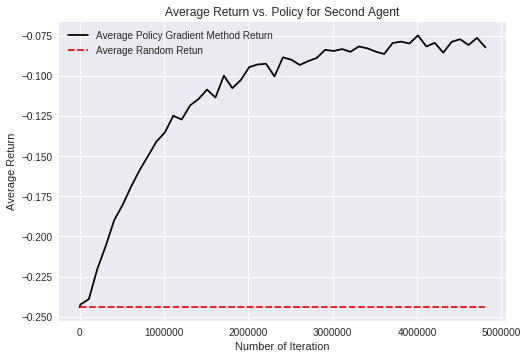

In [108]:
ranom_play=np.zeros(itteration.size)+avg_reward
plt.plot(itteration,avg_method,color=(0,0,0),label='Average Policy Gradient Method Return')
plt.plot(itteration,ranom_play,'r--',label='Average Random Retun')
plt.legend()
plt.xlabel('Number of Iteration')
plt.ylabel('Average Return')
plt.title('Average Return vs. Policy for Second Agent')
plt.show()


In [110]:
print('W:\n',w,'\n')
print('Theta:\n',theta)

W:
 [ 0.44449872 -0.06789564 -0.28582969 -0.01802017] 

Theta:
 [-5.60971188e-18  3.23035180e-19  1.44906461e-19 -9.42286369e-17
 -1.62954016e+00 -1.25595806e+00  1.22414383e+00  1.66135438e+00]
